In [1]:
import torch
import glob
from PIL import Image
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader,  TensorDataset, Dataset
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import math

from os import listdir
import shutil
import time
from tqdm import tqdm

#from torchvision import models, datasets, transforms
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp

import imageio

import pickle

from google.colab import drive
drive.mount('/gdrive')

import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-6swhec1_
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-6swhec1_
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 58 kB 4.4 MB/s 
     |████████████████████████████████| 376 kB 17.5 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0.dev0-py3-none-any.whl size=98008 sha256=29766c618e8d8bdfa3d39a105807739ef04c09e97018990d6437a0fe765f47cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-3jrjekm2/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=a1d1d3e9f18548961

In [2]:
# dataset creating 
class MyDataset(Dataset):
    
    def __init__(self, data, targets, transform=None):
        #self.data = data
        #self.targets = targets
        #self.data.sort()
        #self.targets.sort()
        #self.transform = transform

        self.dir_data = data
        self.dir_targets = targets

        self.list_data = listdir(data)
        self.list_targets = listdir(targets)

        self.list_data.sort()
        self.list_targets.sort()


        
    def __len__(self):
        if len(listdir(self.dir_data)) != len(listdir(self.dir_targets)):
            raise Exception(f'error {len(listdir(self.dir_data))} {len(listdir(self.dir_targets))}')
        return len(listdir(self.dir_data))

    def __getitem__(self, idx):
        #image = self.data[idx]
        #label = self.targets[idx]
        #if self.transform:
            #image = self.transform(image)
        #print(f'{self.dir_data}/{self.list_data[idx]}')
        with open(f'{self.dir_data}/{self.list_data[idx]}', 'rb') as f:
            image = pickle.load(f)

        with open(f'{self.dir_targets}/{self.list_targets[idx]}', 'rb') as f:
            label = pickle.load(f)

        return torch.from_numpy(image).float(), torch.from_numpy(label)

In [3]:
# dataset balanced
dir_img = '/gdrive/My Drive/Segmentation_project/New_bigIms/images_cropped'
dir_mask = '/gdrive/My Drive/Segmentation_project/New_bigIms/masks_cropped'

dataset_balanced = MyDataset(data=dir_img, targets=dir_mask)

#print(len(dataset_balanced))

train_dataset, val_dataset = torch.utils.data.random_split(dataset_balanced, [int(5598*15/18), int(5598*3/18)])
train_loader = DataLoader(train_dataset, batch_size = 18, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 18, shuffle = False)

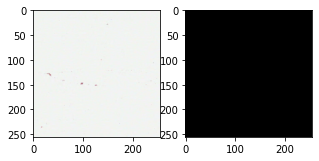

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(5,5))
axes[0].imshow(torch.transpose(torch.transpose(dataset_balanced[120][0], 0, 2), 0, 1))
axes[1].imshow(dataset_balanced[120][1].squeeze(), cmap = 'gray', vmin=0, vmax=1)

In [5]:
# IoU validation metrics
def validate_iou(model, val_loader, device):
    metrics = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        #print(labels.shape, 'labels')
        pred_mask = model(images).to(device)
        pred_mask = (pred_mask > 0.5).float()
        #print(pred_mask.shape, 'pred')
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), labels.long(), mode="binary")
        metrics.append(smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").detach().cpu().numpy())
    
    #print(metrics)
    return np.array(metrics).mean()

In [6]:
# train function
def train(model, num_epochs):
    
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print('Using device:', device)
    
    device = torch.device("cuda")
    
    sum_acc = np.zeros((1,  num_epochs))
    sum_loss = sum_acc.copy()
    model.train()
    model.to(device)

    criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    best_accuracy = 0
    best_loss = 100

    for epoch in tqdm(range(num_epochs)):
        epoch_start = time.time()

        for img_batch, labels_batch in (train_loader):
            # color
            #imag_batch = torchvision.transforms.ColorJitter(brightness=epoch*0.5, contrast=epoch*0.5, saturation=epoch*0.5, hue=epoch*0.5)
            
            # rotation
            #imag_batch = torchvision.transforms.functional.rotate(img_batch, epoch*3.6)
            #labels_batch = torchvision.transforms.functional.rotate(labels_batch, epoch*3.6)
            
            optimizer.zero_grad()
            output = model(img_batch.to(device))            
            loss = criterion(output, labels_batch.to(device).unsqueeze(1))
            loss.backward()
            optimizer.step()

        accuracy = validate_iou(model, val_loader, device)

        if best_accuracy < accuracy:
            best_accuracy = accuracy
            print('Best metrics')
            torch.save(model.state_dict(), '/gdrive/My Drive/Segmentation_project/New_bigIms/model_weights_efficientnet-b0_batch=18_100ep_NewBigIms.pth') #name of saved weights
        if best_loss > loss.cpu().item():
            best_loss = loss.cpu().item()
#             print('Best loss improved')

        sum_acc[0, epoch] = accuracy
        sum_loss[0, epoch] = loss  
        epoch_end = time.time()
        print("Epoch: {} Loss: {:.3f} IoU: {:.3f} Time: {:.4f}s".format(epoch+1, loss.item(), accuracy, epoch_end-epoch_start))
        
    
    return sum_acc, sum_loss

In [7]:
model = smp.Unet(encoder_name='efficientnet-b0', 
                 encoder_depth=5, 
                 encoder_weights='imagenet', 
                 decoder_use_batchnorm=True, 
                 decoder_channels=(256, 128, 64, 32, 16), 
                 decoder_attention_type=None, 
                 in_channels=3, 
                 classes=1, 
                 #activation='sigmoid', 
                 aux_params=None)


accuracy, loss = train(model, 100)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

  1%|          | 1/100 [1:10:31<116:21:25, 4231.17s/it]

Best metrics
Epoch: 1 Loss: 0.293 IoU: 0.764 Time: 4231.1669s


  2%|▏         | 2/100 [1:12:56<49:45:44, 1828.01s/it] 

Best metrics
Epoch: 2 Loss: 0.214 IoU: 0.868 Time: 145.7885s


  3%|▎         | 3/100 [1:15:19<28:31:24, 1058.61s/it]

Epoch: 3 Loss: 0.435 IoU: 0.804 Time: 142.9948s


  4%|▍         | 4/100 [1:17:41<18:34:27, 696.53s/it] 

Epoch: 4 Loss: 0.282 IoU: 0.799 Time: 141.4710s


  5%|▌         | 5/100 [1:20:03<13:06:19, 496.63s/it]

Epoch: 5 Loss: 0.044 IoU: 0.842 Time: 142.1798s


  6%|▌         | 6/100 [1:22:25<9:48:49, 375.84s/it] 

Best metrics
Epoch: 6 Loss: 0.000 IoU: 0.877 Time: 141.3704s


  7%|▋         | 7/100 [1:24:47<7:44:07, 299.43s/it]

Best metrics
Epoch: 7 Loss: 0.094 IoU: 0.880 Time: 142.1046s


  8%|▊         | 8/100 [1:27:09<6:22:24, 249.39s/it]

Epoch: 8 Loss: 0.248 IoU: 0.876 Time: 142.2433s


  9%|▉         | 9/100 [1:29:31<5:27:20, 215.83s/it]

Epoch: 9 Loss: 0.050 IoU: 0.812 Time: 142.0391s


 10%|█         | 10/100 [1:31:53<4:49:22, 192.92s/it]

Epoch: 10 Loss: 0.106 IoU: 0.704 Time: 141.5989s


 11%|█         | 11/100 [1:34:10<4:20:54, 175.89s/it]

Epoch: 11 Loss: 0.000 IoU: 0.803 Time: 137.2800s


 12%|█▏        | 12/100 [1:36:26<4:00:14, 163.81s/it]

Epoch: 12 Loss: 0.736 IoU: 0.877 Time: 136.1688s


 13%|█▎        | 13/100 [1:38:43<3:45:56, 155.83s/it]

Epoch: 13 Loss: 0.041 IoU: 0.865 Time: 137.4642s


 14%|█▍        | 14/100 [1:41:01<3:35:37, 150.44s/it]

Epoch: 14 Loss: 0.000 IoU: 0.825 Time: 137.9810s


 15%|█▌        | 15/100 [1:43:21<3:28:37, 147.27s/it]

Epoch: 15 Loss: 0.068 IoU: 0.866 Time: 139.9244s


 16%|█▌        | 16/100 [1:45:41<3:23:05, 145.06s/it]

Epoch: 16 Loss: 0.000 IoU: 0.866 Time: 139.9287s


 17%|█▋        | 17/100 [1:47:59<3:17:44, 142.94s/it]

Epoch: 17 Loss: 0.126 IoU: 0.751 Time: 138.0096s


 18%|█▊        | 18/100 [1:50:16<3:12:54, 141.16s/it]

Epoch: 18 Loss: 0.065 IoU: 0.859 Time: 137.0007s


 19%|█▉        | 19/100 [1:52:35<3:09:33, 140.41s/it]

Best metrics
Epoch: 19 Loss: 0.083 IoU: 0.888 Time: 138.6736s


 20%|██        | 20/100 [1:54:52<3:05:54, 139.43s/it]

Epoch: 20 Loss: 0.495 IoU: 0.869 Time: 137.1560s


 21%|██        | 21/100 [1:57:10<3:03:03, 139.03s/it]

Epoch: 21 Loss: 0.130 IoU: 0.785 Time: 138.0792s


 22%|██▏       | 22/100 [1:59:30<3:01:01, 139.26s/it]

Epoch: 22 Loss: 0.298 IoU: 0.870 Time: 139.7823s


 23%|██▎       | 23/100 [2:01:49<2:58:30, 139.10s/it]

Best metrics
Epoch: 23 Loss: 0.004 IoU: 0.889 Time: 138.7170s


 24%|██▍       | 24/100 [2:04:08<2:56:24, 139.27s/it]

Best metrics
Epoch: 24 Loss: 0.060 IoU: 0.897 Time: 139.6873s


 25%|██▌       | 25/100 [2:06:26<2:53:37, 138.89s/it]

Epoch: 25 Loss: 0.084 IoU: 0.860 Time: 138.0013s


 26%|██▌       | 26/100 [2:08:46<2:51:31, 139.07s/it]

Epoch: 26 Loss: 0.084 IoU: 0.605 Time: 139.4811s


 27%|██▋       | 27/100 [2:11:06<2:49:37, 139.42s/it]

Epoch: 27 Loss: 0.139 IoU: 0.896 Time: 140.2344s


 28%|██▊       | 28/100 [2:13:27<2:47:57, 139.97s/it]

Epoch: 28 Loss: 0.000 IoU: 0.882 Time: 141.2486s


 29%|██▉       | 29/100 [2:15:46<2:45:04, 139.50s/it]

Epoch: 29 Loss: 0.000 IoU: 0.891 Time: 138.4143s


 30%|███       | 30/100 [2:18:04<2:42:12, 139.03s/it]

Epoch: 30 Loss: 0.171 IoU: 0.891 Time: 137.9312s


 30%|███       | 30/100 [2:18:31<5:23:13, 277.06s/it]


KeyboardInterrupt: ignored

In [ ]:
np.save('/gdrive/My Drive/Segmentation_project/new_datasets/acc_efficientnet-b0_batch=26_100ep_NEW_color.npy', accuracy)
np.save('/gdrive/My Drive/Segmentation_project/new_datasets/loss_efficientnet-b0_batch=26_100ep_NEW_color.npy', loss)

In [ ]:
#model = smp.DeepLabV3Plus(encoder_name='efficientnet-b4', 
#                          encoder_depth=5,
#                          encoder_weights='imagenet',
#                          encoder_output_stride=16,
#                          decoder_channels=256,
#                          decoder_atrous_rates=(12, 24, 36),
#                          in_channels=3,
#                          classes=1,
#                          activation=None,
#                          upsampling=4,
#                          aux_params=None)

#accuracy, loss = train(model, 100)

In [ ]:
#type(accuracy)
#type(loss)

In [ ]:
#accuracy = accuracy
#loss_final = loss

In [ ]:
#torch.save(model.state_dict(), '/gdrive/My Drive/Segmentation_project/weights/model_weights_efficientnet-b0_batch=52_100epochs.pth')